# Encontrar último bias da rede neural
### Cenário
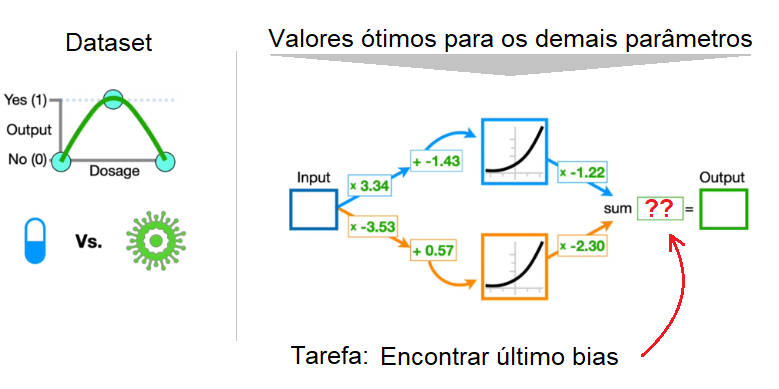

### Sobre esta rede neural
É rede neural composta por uma camada oculta com dois neurônios.

* O input passa por dois pesos (w1 e w2), sendo distribuído para dois neurônios na camada oculta.
* Cada neurônio na camada oculta possui pesos e um bias (b1 e b2), seguido de uma função de ativação.
* As saídas desses dois neurônios são então combinadas após os pesos w3 e w4, e fazem conexões com um único neurônio na camada de saída.
* O neurônio final recebe também um bias (b3) antes de gerar a saída da rede.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### Dados

In [ ]:
simple_dataset = {'dosage': [[0], [.5], [1]],
                  'label': [[0], [1], [0]]}
dataset_tensor = torch.tensor(simple_dataset['dosage'],
                              dtype=torch.float32, requires_grad=True)
y_true = torch.tensor(simple_dataset['label'], dtype=torch.float32)

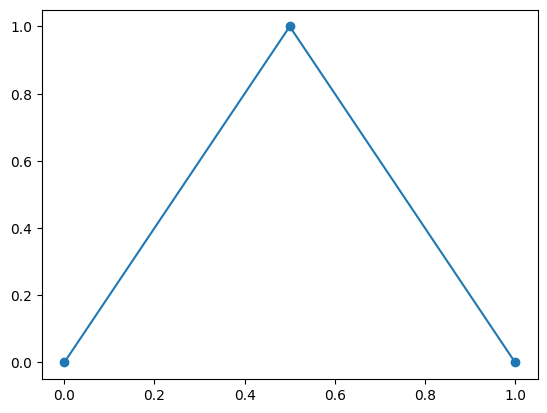

In [ ]:
plt.scatter(simple_dataset['dosage'], simple_dataset['label'])
plt.plot(simple_dataset['dosage'], simple_dataset['label'])
plt.show()

## Criar os pesos e bias da rede de acordo com os valores da imagem

In [ ]:
# Definir os pesos e biases conforme descrito na rede
w1 = torch.tensor(3.34)
w2 = torch.tensor(-3.53)

b1 = torch.tensor(-1.43)
b2 = torch.tensor(0.57)

w3 = torch.tensor(-1.22)
w4 = torch.tensor(-2.3)

## Calculando as Saídas da Rede
A rede tem a seguinte estrutura:

1. Entrada: x
2. Primeira transformação: Multiplicação por $w_1$ ou $w_2$, depois soma com $b_1$ ou $b_2$
3. Ativação: Aplicamos Softplus
4. Segunda transformação: Multiplicação pelo próximo peso $w_3$ ou $w_4$, somamos $b_3$ (que queremos encontrar)
5. Saída final

> Função de ativação Sotfplus: $f(x)=log(1+e^x)$

### Teste da rede com apenas o chute inicial para b3 (valor não otimizado)

In [ ]:
activation = torch.nn.Softplus()

x = torch.tensor([[0.6]])

# Primeira transformação
h1 = activation(w1 * x + b1)
h2 = activation(w2 * x + b2)

# Combinação das saídas dos dois neurônios
y_pred = (w3 * h1) + (w4 * h2)

b3 = torch.tensor(0.0)  # chute inicial de bias são definidos como 0
output = y_pred + b3

print(f"Saída final da rede: {output.tolist()}")

Saída final da rede: [[-1.6888515949249268]]


Este resultado reflete o cenário da imagem abaixo, quando b3=0:

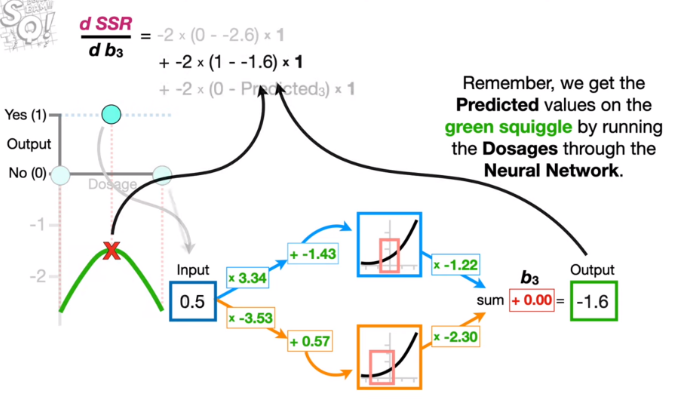


### Calculando SSR
O SSR (Sum of Squared Residuals) mede o erro entre as previsões da rede e os valores reais.
Esse cálculo é dado pela função:

$$SSR=∑ (y_{pred} + b3 −y_{true})^2$$

Dessa forma, é preciso calcular essa função para depois ajustar $b_3$.

In [ ]:
dataset_tensor.shape

torch.Size([3, 1])

In [ ]:
# Primeira transformação (agora com os dados do dataset original)
h1 = activation(w1 * dataset_tensor + b1)
h2 = activation(w2 * dataset_tensor + b2)

b3 = torch.tensor(0.0, requires_grad=True) # reinicializando b3 com requires_grad=True para que seja possível fazer a otimização

# Combinação das saídas dos dois neurônios
y_pred = (w3 * h1) + (w4 * h2)
y_pred += b3.expand_as(y_pred) # saída agora com b3, computando para cada amostra

# Calculando SSR
SSR = torch.sum((y_pred - y_true) ** 2)

print("Valor de SSR inicial:", SSR.item())

Valor de SSR inicial: 20.42359733581543


Como obtido em:

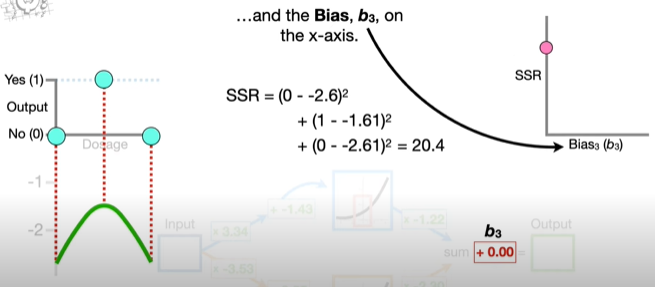

### Calculando o Gradiente de $b_3$

Como queremos minimizar o erro, usamos o gradiente descendente, que atualiza $b_3$ de acordo com a derivada de SSR em relação a $b_3$.

Essa atualização é dada por:

$b_3 = b_3 - α . (dSSR/db_3$)

onde α é a taxa de aprendizado.

In [ ]:
learning_rate = 0.1

# Usando autograd para calcular o gradiente
SSR.backward() # pra obter o slope da reta que tangencia ssr onde x=b3 atraves de dSSR/db3 -- derivada de ssr em relação a b3

# Atualizando b3 usando gradiente descendente
with torch.no_grad():  # Evita rastrear essa operação para que o gradiente nãoa acumule
    b3 -= learning_rate * b3.grad  # Atualização de b3

    b3.grad.zero_()  # Zera o gradiente para próxima iteração

print("Novo valor de b3:", b3.item())

Novo valor de b3: 1.565510869026184


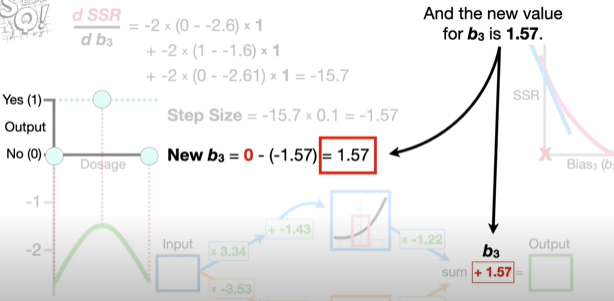

### Treinando $b_3$ com Gradiente Descendente
Agora o processo será repetido n vezes para minimizar SSR:
1. Calcular a predição da rede.
2. Calcular o erro SSR.
3. Calcular o gradiente de $b_3$.
4. Atualizar $b_3$ com gradiente descendente.
5. Repetir até a convergência, ou até chegar no número de iterações definido

In [ ]:
num_epochs = 100  # iterações do gradiente descendente
learning_rate = 0.1

#b3 = torch.tensor(0.0, requires_grad=True)

b3_history = []
SSR_history = []

# treinamento
for epoch in range(num_epochs):
    # Recalcula h1 e h2 (primeira transformação, até chegar na função de ativação)
    h1 = activation(w1 * dataset_tensor + b1)
    h2 = activation(w2 * dataset_tensor + b2)

    # Forward pass (após a função de ativação ainda passará pelos pesos w3 e w4, e então serão combinados os resultados)
    output = (w3 * h1) + (w4 * h2) + b3

    # SSR: o erro entre cada amostra predita e a real
    SSR = torch.sum((y_true - output) ** 2)

    # Backpropagation (dSSR/db3)
    SSR.backward()

    # atualização de b3
    with torch.no_grad():
        b3 -= learning_rate * b3.grad  # Atualiza b3 com o stepsize
        #print(f"Gradiente de b3: {b3.grad}")
        b3.grad.zero_()  # Zera o gradiente para próxima iteração

    # progresso
    if epoch % 10 == 0:
        print(f"Época {epoch}: SSR = {SSR.item()}, b3 = {b3.item()}")

    b3_history.append(b3.item())
    SSR_history.append(SSR.item())

# Resultado final
print("Valor final otimizado de b3:", b3.item())

Época 0: SSR = 3.2678279876708984, b3 = 2.1917152404785156
Época 10: SSR = 6.28470879746601e-05, b3 = 2.6091408729553223
Época 20: SSR = 6.281118839979172e-05, b3 = 2.609184741973877
Época 30: SSR = 6.281118839979172e-05, b3 = 2.609184741973877
Época 40: SSR = 6.281118839979172e-05, b3 = 2.609184741973877
Época 50: SSR = 6.281118839979172e-05, b3 = 2.609184741973877
Época 60: SSR = 6.281118839979172e-05, b3 = 2.609184741973877
Época 70: SSR = 6.281118839979172e-05, b3 = 2.609184741973877
Época 80: SSR = 6.281118839979172e-05, b3 = 2.609184741973877
Época 90: SSR = 6.281118839979172e-05, b3 = 2.609184741973877
Valor final otimizado de b3: 2.609184741973877


Como obtido em:

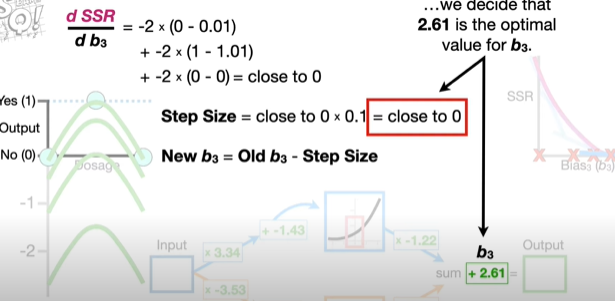

### Visualizando a convergência de $b_3$

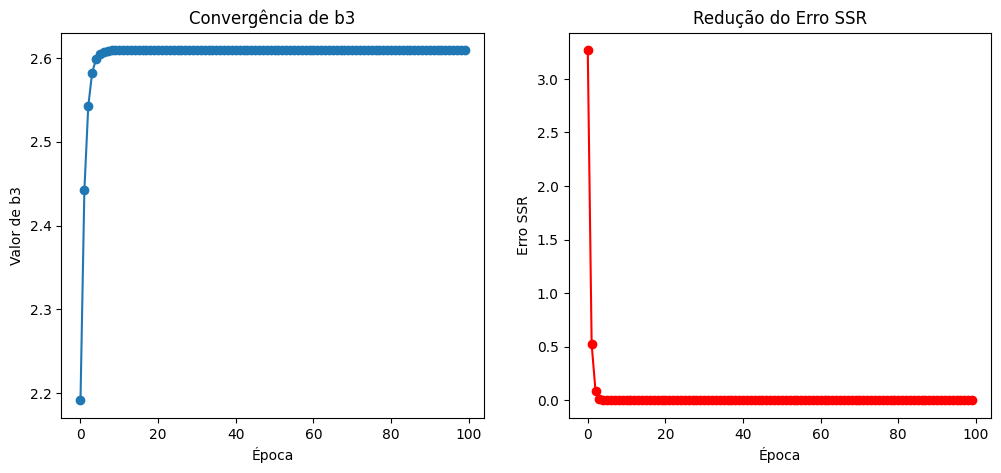

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(b3_history, marker='o', linestyle='-')
plt.xlabel('Época')
plt.ylabel('Valor de b3')
plt.title('Convergência de b3')

plt.subplot(1, 2, 2)
plt.plot(SSR_history, marker='o', linestyle='-', color='r')
plt.xlabel('Época')
plt.ylabel('Erro SSR')
plt.title('Redução do Erro SSR')

plt.show()